In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.utils import resample

C:\Users\Adam Yang\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
train_df = pd.read_csv('fraudTrain.csv')
test_df = pd.read_csv('fraudTest.csv')
fraud_df = pd.concat([train_df, test_df])
fraud_df = fraud_df.reset_index(drop=True)
# index - Unique Identifier for each row
# transdatetrans_time - Transaction DateTime
# cc_num - Credit Card Number of Customer
# merchant - Merchant Name
# category - Category of Merchant
# amt - Amount of Transaction
# first - First Name of Credit Card Holder
# last - Last Name of Credit Card Holder
# gender - Gender of Credit Card Holder
# street - Street Address of Credit Card Holder
# city - City of Credit Card Holder
# state - State of Credit Card Holder
# zip - Zip of Credit Card Holder
# lat - Latitude Location of Credit Card Holder
# long - Longitude Location of Credit Card Holder
# city_pop - Credit Card Holder's City Population
# job - Job of Credit Card Holder
# dob - Date of Birth of Credit Card Holder
# trans_num - Transaction Number
# unix_time - UNIX Time of transaction
# merch_lat - Latitude Location of Merchant
# merch_long - Longitude Location of Merchant
# is_fraud - Fraud Flag <--- Target Class

print("Shape of total dataset is:", fraud_df.shape)
# fraud_df.head()

Shape of total dataset is: (1852394, 23)


In [3]:
fraud_df.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [4]:
fraud_df['is_fraud'].value_counts()

0    1842743
1       9651
Name: is_fraud, dtype: int64

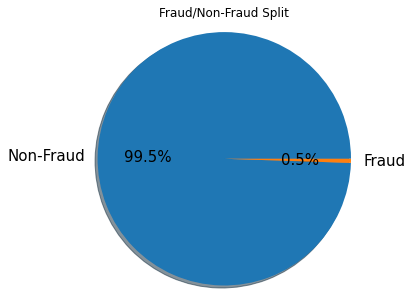

In [5]:
# Explore imbalanced data
data_imbalance_group = fraud_df['is_fraud'].value_counts()
# region_groups = region_groups.sort_values()
labels = ['Non-Fraud', 'Fraud']
colors = ['#ADD8E6', '#FFD580']
sizes = data_imbalance_group.values
explode = (0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

# plt.figure(figsize=(10,10))
fig1, ax1 = plt.subplots(figsize=(5, 5))
# plt.rc('font', size=15)          # controls default text sizes
# plt.rc('legend', fontsize=25)    # legend fontsize
ax1.pie(sizes, explode=explode, labels=labels, shadow=True, autopct='%1.1f%%', startangle=0, textprops={'fontsize': 15})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Fraud/Non-Fraud Split")


plt.show()

# Data Preprocessing

In [6]:
def EDA_data_preprocessing(df):
    # DROP UNNECESSARY COLUMNS
    drop_columns = ['Unnamed: 0', 'cc_num', 'merchant', 
                    'first', 'last', 'unix_time', 'trans_num', 'street',
                   'city', 'job']
    df = df.drop(drop_columns, axis=1)
    
    # CREATE HOUR, DAY, AND MONTH COLUMNS
    df['hour'] = pd.to_datetime(df['trans_date_trans_time']).dt.hour
    df['day_of_week'] = pd.to_datetime(df['trans_date_trans_time']).dt.dayofweek
    df['month'] = pd.to_datetime(df['trans_date_trans_time']).dt.month
    
#     # CREATE MAPPINGS FOR DAY AND MONTH
#     day_mapping = {0:"Mon", 1:"Tue", 2:"Wed", 3:"Thur", 4:"Fri", 5:"Sat", 6:"Sun"}
#     month_mapping = {1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 
#                      7:"Jul", 8:"Aug", 9:"Sep", 10:"Oct", 11:"Nov", 12:"Dec"}
#     df['day_of_week'] = df['day_of_week'].map(day_mapping)
#     df['month'] = df['month'].map(month_mapping)

    # CREATE AGE COLUMN BASED ON DATE-OF-BIRTH AND TRANSACTION DATE
    df['age'] = pd.to_datetime(df['trans_date_trans_time']).dt.year - pd.to_datetime(df['dob']).dt.year
    df = df.drop('dob', axis=1)
    df = df.drop('trans_date_trans_time', axis=1)
    
    # CREATE AGE GROUP COLUMN BASED ON AGE COLUMNS
    bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99']
    df['age_group'] = pd.cut(df['age'], bins, labels = labels,include_lowest = True)
    
#     # CREATE AMOUNT GROUP COLUMN BASED ON AMOUNT COLUMN
#     bins = [0, 500, 1000, 1500, 2000, 50, 60, 70, 80, 90, 100]
#     labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99']
#     df['amt_group'] = pd.cut(df['amt'], bins, labels = labels,include_lowest = True)
    
    # RENAME TRANSACTION CATEGORIES TO BE MORE CLEAR
    trans_category_map = {'gas_transport': 'Gas', 
                          'grocery_pos': 'Grocery Inperson',
                          'home': 'Home Goods',
                          'shopping_pos': 'Shopping Inperson',
                          'kids_pets': 'Kids/Pets',
                          'shopping_net': 'Shopping Online',
                          'entertainment': 'Entertainment',
                          'food_dining': 'Restaurants',
                          'personal_care': 'Personal Care',
                          'health_fitness': 'Health/Fitness',
                          'misc_pos': 'Misc Inperson',
                          'misc_net': 'Misc Online',
                          'grocery_net': 'Grocery Online',
                          'travel': 'Travel'
                        }
    df['category'] = df['category'].map(trans_category_map)
    
    # CATEGORIZE STATES INTO US REGIONS
    state_region_map = {}
    # Create West Region Map
    west_states = ['AK', 'AZ', 'CA', 
                   'CO', 'HI', 'ID', 
                   'MT', 'NV', 'NM', 
                   'OR', 'UT', 'WA', 'WY']
    west_region = ['West' for i in range(len(west_states))]
    west_states_map = dict(zip(west_states, west_region))
    state_region_map.update(west_states_map)

    # Create Midwest Region Map
    midwest_states = ['IL', 'IN', 'IA', 'KS', 'MI', 'MN', 'MO', 
                      'NE', 'ND', 'OH', 'SD', 'WI']
    midwest_region = ['Midwest' for i in range(len(midwest_states))]
    midwest_states_map = dict(zip(midwest_states, midwest_region))
    state_region_map.update(midwest_states_map)

    # Create Northeast Region Map
    northeast_states = ['CT', 'ME', 'MA', 'NH', 'NJ', 'NY', 
                 'PA', 'RI', 'VT']
    northeast_region = ['Northeast' for i in range(len(northeast_states))]
    northeast_states_map = dict(zip(northeast_states, northeast_region))
    state_region_map.update(northeast_states_map)

    # Create South Region Map
    south_states = ['AL', 'AR', 'DE', 'FL', 'GA', 'KY', 'LA', 
                    'MD', 'MS', 'NC', 'OK', 'SC', 'TN', 
                    'TX', 'VA', 'WV']
    south_region = ['South' for i in range(len(south_states))]
    south_states_map = dict(zip(south_states, south_region))
    state_region_map.update(south_states_map)

    # Apply final map to states
    df['region'] = df['state'].map(state_region_map)
    return df



In [7]:
def ML_data_preprocessing(df):
    # DROP UNNECESSARY COLUMNS
    drop_columns = ['Unnamed: 0', 'cc_num', 'merchant', 
                    'first', 'last', 'unix_time', 'trans_num', 'street',
                   'city', 'job']
    df = df.drop(drop_columns, axis=1)
    
    # CREATE GENDER MAPPING
    gender_mapping = {'M':1,'F':0}
    df['gender_bin'] = df['gender'].map(gender_mapping)
    df = df.drop('gender', axis=1)
    
    # CREATE HOUR, DAY, AND MONTH COLUMNS
    df['hour'] = pd.to_datetime(df['trans_date_trans_time']).dt.hour
    df['day_of_week'] = pd.to_datetime(df['trans_date_trans_time']).dt.dayofweek
    df['month'] = pd.to_datetime(df['trans_date_trans_time']).dt.month

    # CREATE AGE COLUMN BASED ON DATE-OF-BIRTH AND TRANSACTION DATE
    df['age'] = pd.to_datetime(df['trans_date_trans_time']).dt.year - pd.to_datetime(df['dob']).dt.year
    df = df.drop('dob', axis=1)
    df = df.drop('trans_date_trans_time', axis=1)

    # RENAME TRANSACTION CATEGORIES TO BE MORE CLEAR
    trans_category_map = {'gas_transport': 'Gas', 
                          'grocery_pos': 'Grocery Inperson',
                          'home': 'Home Goods',
                          'shopping_pos': 'Shopping Inperson',
                          'kids_pets': 'Kids/Pets',
                          'shopping_net': 'Shopping Online',
                          'entertainment': 'Entertainment',
                          'food_dining': 'Restaurants',
                          'personal_care': 'Personal Care',
                          'health_fitness': 'Health/Fitness',
                          'misc_pos': 'Misc Inperson',
                          'misc_net': 'Misc Online',
                          'grocery_net': 'Grocery Online',
                          'travel': 'Travel'
                        }
    df['category'] = df['category'].map(trans_category_map)
    
    # ONE-HOT ENCODE THE CATEGORIES AND REGION
    category_df = pd.get_dummies(df['category'], prefix='Category')
    df = df.drop('category', axis=1)
    state_df = pd.get_dummies(df['state'], prefix='State')
    df = df.drop('state', axis=1)
    df = pd.concat([df, category_df, state_df], axis=1)

    return df



In [8]:
# CREATE DATASET FOR EXPLORATORY DATA ANALYSIS PURPOSES
fraud_df_eda = fraud_df.copy()
eda_df_prep = EDA_data_preprocessing(fraud_df_eda)
eda_df_prep

,category,amt,gender,state,zip,lat,long,city_pop,merch_lat,merch_long,is_fraud,hour,day_of_week,month,age,age_group,region
0,Misc Online,4.97,F,NC,28654,36.0788,-81.1781,3495,36.011293,-82.048315,0,0,1,1,31,30-39,South
1,Grocery Inperson,107.23,F,WA,99160,48.8878,-118.2105,149,49.159047,-118.186462,0,0,1,1,41,40-49,West
2,Entertainment,220.11,M,ID,83252,42.1808,-112.2620,4154,43.150704,-112.154481,0,0,1,1,57,50-59,West
3,Gas,45.00,M,MT,59632,46.2306,-112.1138,1939,47.034331,-112.561071,0,0,1,1,52,50-59,West
4,Misc Inperson,41.96,M,VA,24433,38.4207,-79.4629,99,38.674999,-78.632459,0,0,1,1,33,30-39,South
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852389,Health/Fitness,43.77,M,MO,63453,40.4931,-91.8912,519,39.946837,-91.333331,0,23,3,12,54,50-59,Midwest
1852390,Kids/Pets,111.84,M,TX,77566,29.0393,-95.4401,28739,29.661049,-96.186633,0,23,3,12,21,20-29,South
1852391,Kids/Pets,86.88,F,WA,99323,46.1966,-118.9017,3684,46.658340,-119.715054,0,23,3,12,39,30-39,West
1852392,Travel,7.99,M,ID,83643,44.6255,-116.4493,129,44.470525,-117.080888,0,23,3,12,55,50-59,West


In [9]:
# CREATE DATASET FOR MACHINE LEARNING PURPOSES
fraud_df_ML = fraud_df.copy()
ML_df_prep = ML_data_preprocessing(fraud_df_ML)
ML_df_prep

,amt,zip,lat,long,city_pop,merch_lat,merch_long,is_fraud,gender_bin,hour,...,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY
0,4.97,28654,36.0788,-81.1781,3495,36.011293,-82.048315,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,107.23,99160,48.8878,-118.2105,149,49.159047,-118.186462,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,220.11,83252,42.1808,-112.2620,4154,43.150704,-112.154481,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,45.00,59632,46.2306,-112.1138,1939,47.034331,-112.561071,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,41.96,24433,38.4207,-79.4629,99,38.674999,-78.632459,0,1,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852389,43.77,63453,40.4931,-91.8912,519,39.946837,-91.333331,0,1,23,...,0,0,0,0,0,0,0,0,0,0
1852390,111.84,77566,29.0393,-95.4401,28739,29.661049,-96.186633,0,1,23,...,0,0,1,0,0,0,0,0,0,0
1852391,86.88,99323,46.1966,-118.9017,3684,46.658340,-119.715054,0,0,23,...,0,0,0,0,0,0,1,0,0,0
1852392,7.99,83643,44.6255,-116.4493,129,44.470525,-117.080888,0,1,23,...,0,0,0,0,0,0,0,0,0,0


# Exploratory Data Analysis

In [ ]:
# Explore insights on state and region
region_groups = eda_df_prep.groupby(['region'])['is_fraud'].sum()
region_groups = region_groups.sort_values()
xAxis = region_groups.index
yAxis = region_groups.values
plt.bar(xAxis,yAxis)
plt.title('Fraud in each Region')
plt.xlabel('Region')
plt.ylabel('Number of Fraud Transactions')
plt.show()

region_groups = eda_df_prep.groupby(['region'])['region'].count()
region_groups = region_groups.sort_values()
xAxis = region_groups.index
yAxis = region_groups.values
plt.bar(xAxis,yAxis)
plt.title('Population in each Region')
plt.xlabel('Region')
plt.ylabel('Population')
plt.show()

state_groups = eda_df_prep.groupby(['state'])['is_fraud'].sum()
# city_pop = eda_df_prep.groupby(['state'])['city_pop'].sum()
# state_groups = state_groups / city_pop
# state_groups = state_groups.sort_values()
# median_value = state_groups.median()
xAxis = state_groups.index
yAxis = state_groups.values
plt.figure(figsize=(12, 12))
plt.barh(xAxis,yAxis)
plt.title('Fraud in each state')
plt.ylabel('State')
plt.xlabel('Number of Fraud Transactions')
plt.show()

state_groups = eda_df_prep.groupby(['state'])['state'].count()
# city_pop = eda_df_prep.groupby(['state'])['city_pop'].sum()
# state_groups = state_groups / city_pop
# state_groups = state_groups.sort_values()
# median_value = state_groups.median()
xAxis = state_groups.index
yAxis = state_groups.values
plt.figure(figsize=(12, 12))
plt.barh(xAxis,yAxis)
plt.title('Population in each state')
plt.ylabel('State')
plt.xlabel('Population')
plt.show()

In [ ]:
# Explore insights on transaction category
region_groups = eda_df_prep.groupby(['category'])['is_fraud'].sum()
region_groups
region_groups = region_groups.sort_values()
xAxis = region_groups.index
yAxis = region_groups.values

plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.size': 14})
plt.barh(xAxis,yAxis)
plt.title('Fraud in each category')
plt.ylabel('Transaction Category')
plt.xlabel('Number of Fraud Transactions')

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 18

# # plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
# # plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.show()

In [ ]:
# Explore insights on age category
# amounts = eda_df_prep['age']
# labels = eda_df_prep['is_fraud']
# plt.figure(figsize=(10,5))
# plt.scatter(amounts, labels)

# ages = eda_df_prep.groupby(['age_group']).counts()

age_groups = eda_df_prep.groupby(['age_group'])['is_fraud'].sum()
# age_groups = age_groups.sort_values()
xAxis = age_groups.index
yAxis = age_groups.values

plt.figure(figsize=(8, 8))
plt.rcParams.update({'font.size': 14})
plt.barh(xAxis,yAxis)
plt.title('Fraud vs. Age Group')
plt.ylabel('Age Group')
plt.xlabel('Number of Fraud Transactions')

In [ ]:
ages = eda_df_prep.groupby(['age_group'])['age_group'].count()


xAxis = ages.index
yAxis = ages.values

plt.figure(figsize=(8, 8))
plt.rcParams.update({'font.size': 14})
plt.barh(xAxis,yAxis)
plt.title('Population in Age Group')
plt.ylabel('Age Group')
plt.xlabel('Population Size')

In [ ]:
# Explore insights on amount category
amt_groups = eda_df_prep.groupby(['is_fraud'])
fraud_group = amt_groups.get_group(1)
non_fraud_group = amt_groups.get_group(0)

my_dict = {'Fraud': fraud_group['amt'], 'Not Fraud': non_fraud_group['amt']}

plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(9,4))
ax.boxplot(my_dict.values(), vert=False)
ax.set_yticklabels(my_dict.keys())
ax.set_xlabel('Transaction Amount')

In [ ]:
# Explore insights on month category
month_groups = eda_df_prep.groupby(['month'])['is_fraud'].sum()
xAxis = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
yAxis = month_groups.values
plt.figure(figsize=(8,4))
plt.bar(xAxis,yAxis)
plt.title('Number of Frauds vs. Month')
plt.xlabel('Month')
plt.ylabel('Number of Fraud Transactions')
plt.xticks(range(0, 12))
plt.show()

In [ ]:
# Explore insights on day of week category
dow_groups = eda_df_prep.groupby(['day_of_week'])['is_fraud'].sum()
xAxis = ["Mon", "Tue", "Wed", "Thur", "Fri", "Sat", "Sun"]
yAxis = dow_groups.values
plt.figure(figsize=(8, 4))
plt.bar(xAxis,yAxis)
plt.title('Number of Frauds vs. Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Fraud Transactions')
# plt.xticks(range(1, 13))
plt.show()

In [ ]:
# Explore insights on hour category
hour_groups = eda_df_prep.groupby(['hour'])['is_fraud'].sum()
xAxis = hour_groups.index
yAxis = hour_groups.values
plt.figure(figsize=(9, 5))
plt.bar(xAxis,yAxis)
plt.title('Number of Frauds vs. Hour')
plt.xlabel('Hour')
plt.ylabel('Number of Fraud Transactions')
plt.xticks(range(0,24))
plt.show()

In [ ]:
# Explore insights on Transaction distance category
trans_distance = (eda_df_prep['lat']-eda_df_prep['merch_lat'])**2 + (eda_df_prep['long']-eda_df_prep['merch_long'])**2
print("Completed Processing")
xAxis = trans_distance
yAxis = eda_df_prep['is_fraud']
plt.figure(figsize=(8, 4))
plt.scatter(xAxis, yAxis)
plt.title('Is Fraud vs. Transaction Distance')
plt.xlabel('Transaction Distance')
plt.ylabel('Is Fraud')
plt.show()

In [ ]:
# Explore insights on gender category
gender_groups = eda_df_prep.groupby(['gender'])['is_fraud'].sum()
# region_groups = region_groups.sort_values()
labels = gender_groups.index
sizes = gender_groups.values
explode = (0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

# plt.figure(figsize=(10,10))
fig1, ax1 = plt.subplots(figsize=(5, 5))
# plt.rc('font', size=15)          # controls default text sizes
# plt.rc('legend', fontsize=25)    # legend fontsize
ax1.pie(sizes, explode=explode, labels=labels, shadow=True, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 15})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Gender Split in Fraudulent Transactions")


plt.show()

In [ ]:
# Explore insights on city_pop category
population = eda_df_prep['city_pop']
labels = eda_df_prep['is_fraud']
plt.figure(figsize=(10,5))
plt.scatter(population, labels)

# Machine Learning Models

In [10]:
def resampling(df):
    # RESAMPLE THE DATA TO MITIGATE IMBALANCE

    df_majority = df[df['is_fraud'] == 0] # Filters minorities and keeps majority class labels
    df_minority = df[df['is_fraud'] == 1] # Filters majorities and keeps minority class labels

    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=25000)    # to match majority class

    # Undersample majority class
    df_majority_undersampled = resample(df_majority, 
                                     replace=True,     # sample with replacement
                                     n_samples=25000)    # to match majority class

    # Combine majority class with upsampled minority class
    df_resampled = pd.concat([df_majority_undersampled, df_minority_upsampled])
    
    return df_resampled


In [11]:
ML_df_resampled = resampling(ML_df_prep)

In [12]:
ML_df_resampled['is_fraud'].value_counts()

0    25000
1    25000
Name: is_fraud, dtype: int64

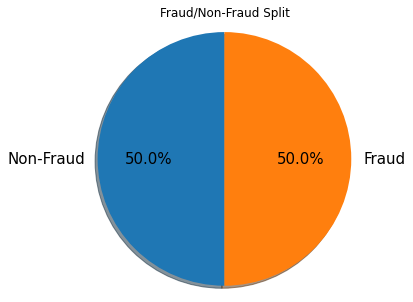

In [13]:
# Explore balanced data
data_balance_group = ML_df_resampled['is_fraud'].value_counts()
# region_groups = region_groups.sort_values()
labels = ['Non-Fraud', 'Fraud']
colors = ['#ADD8E6', '#FFD580']
sizes = data_balance_group.values
explode = (0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

# plt.figure(figsize=(10,10))
fig1, ax1 = plt.subplots(figsize=(5, 5))
# plt.rc('font', size=15)          # controls default text sizes
# plt.rc('legend', fontsize=25)    # legend fontsize
ax1.pie(sizes, explode=explode, labels=labels, shadow=True, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 15})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Fraud/Non-Fraud Split")


plt.show()

In [14]:
y = ML_df_resampled['is_fraud']
X = ML_df_resampled.drop('is_fraud', axis=1)



# PERFORM 70-30 SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

print("Train data:",  X_train.shape, y_train.shape)
print("Test data:",  X_test.shape, y_test.shape)

# imb_resampler = SMOTE()
# X_train_resampled, y_train_resampled = imb_resampler.fit_resample(X_train, y_train)

Train data: (35000, 77) (35000,)
Test data: (15000, 77) (15000,)


In [15]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Test Confusion Matrix')
    plt.show()

    tn, fp, fn, tp = cm.ravel()
    tn, fp, fn, tp
    p = tp/(tp+fp)
    r = tp/(tp+fn)
    print('Test Accuracy: ', accuracy_score(y_test, y_pred))
    print("Precision Score:", p)
    print("Recall Score:", r)
    print("F1 Score:", (2*p*r)/(p+r))

C:\Users\Adam Yang\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


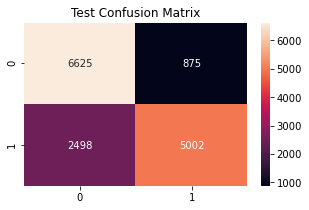

Test Accuracy:  0.7751333333333333
Precision Score: 0.8511145142079292
Recall Score: 0.6669333333333334
F1 Score: 0.7478507886671151


In [16]:
# LOGISTIC REGRESSION MODEL
log_clf = LogisticRegression(solver='sag')
evaluate_model(log_clf, X_train, X_test, y_train, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


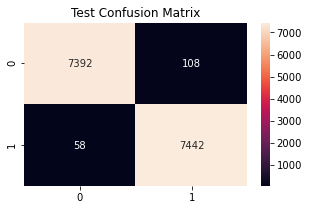

Test Accuracy:  0.9889333333333333
Precision Score: 0.9856953642384106
Recall Score: 0.9922666666666666
F1 Score: 0.9889700996677739


In [30]:
# RANDOM FOREST MODEL
random_forest_clf = RandomForestClassifier(max_depth=100, min_samples_split=3, verbose=2)
evaluate_model(random_forest_clf, X_train, X_test, y_train, y_test)

[LibSVM]

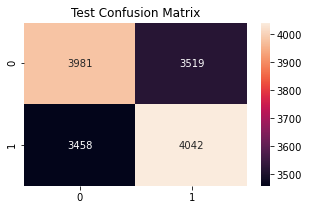

Test Accuracy:  0.5348666666666667
Precision Score: 0.5345853723052506
Recall Score: 0.5389333333333334
F1 Score: 0.5367505477723923


In [18]:
# SUPPORT VECTOR MACHINE MODEL
svm_clf = svm.SVC(verbose=True)
evaluate_model(svm_clf, X_train, X_test, y_train, y_test)

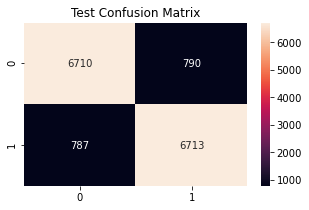

Test Accuracy:  0.8948666666666667
Precision Score: 0.8947087831534053
Recall Score: 0.8950666666666667
F1 Score: 0.8948876891288409


In [19]:
# K-NEAREST NEIGHBORS
knn_clf = KNeighborsClassifier(n_neighbors=5)
evaluate_model(knn_clf, X_train, X_test, y_train, y_test)

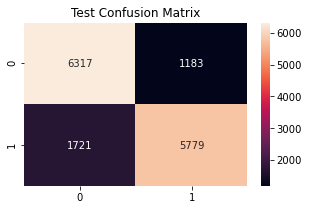

Test Accuracy:  0.8064
Precision Score: 0.8300775639184143
Recall Score: 0.7705333333333333
F1 Score: 0.7991978979394274


In [20]:
# DEEP LEARNING MODEL
mlp_clf = MLPClassifier(random_state=1, max_iter=300)
evaluate_model(mlp_clf, X_train, X_test, y_train, y_test)

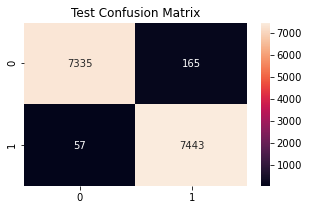

Test Accuracy:  0.9852
Precision Score: 0.9783123028391167
Recall Score: 0.9924
F1 Score: 0.9853057982525815


In [29]:
# DECISION TREE CLASSIFIER MODEL
dt_clf = DecisionTreeClassifier(max_depth=100, min_samples_split=3)
evaluate_model(dt_clf, X_train, X_test, y_train, y_test)

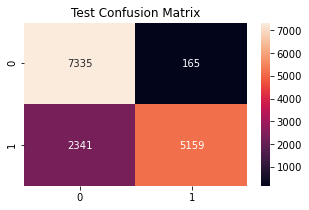

Test Accuracy:  0.8329333333333333
Precision Score: 0.96900826446281
Recall Score: 0.6878666666666666
F1 Score: 0.8045851528384279


In [22]:
# GAUSSIAN NAIVE BAYES CLASSIFICATIONS MODEL
gnb_clf = GaussianNB()
evaluate_model(gnb_clf, X_train, X_test, y_train, y_test)

# MORE COMPLEX MODELS

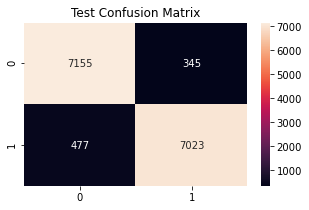

Test Accuracy:  0.9452
Precision Score: 0.9531758957654723
Recall Score: 0.9364
F1 Score: 0.9447134786117838


In [15]:
# ADABOOST CLASSIFIER MODEL
adaboost_clf = AdaBoostClassifier(n_estimators=100)
evaluate_model(adaboost_clf, X_train, X_test, y_train, y_test)

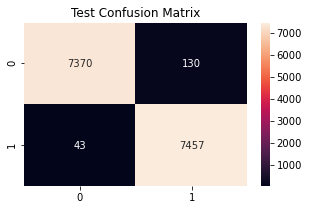

Test Accuracy:  0.9884666666666667
Precision Score: 0.9828654277052854
Recall Score: 0.9942666666666666
F1 Score: 0.988533174255982


In [16]:
# BAGGING CLASSIFIER MODEL
dt_base_estimator = DecisionTreeClassifier(max_depth=100, min_samples_split=3)
bagging_clf = BaggingClassifier(base_estimator=dt_base_estimator, n_estimators=100)
evaluate_model(bagging_clf, X_train, X_test, y_train, y_test)

building tree 1 of 100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   15.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished


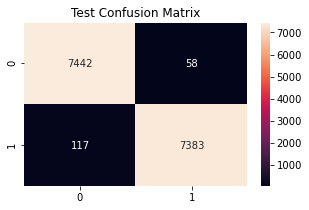

Test Accuracy:  0.9883333333333333
Precision Score: 0.9922053487434485
Recall Score: 0.9844
F1 Score: 0.9882872632353925


In [17]:
# EXTRA TREES CLASSIFIER MODEL
extratree_clf = ExtraTreesClassifier(n_estimators=100, max_depth=100, min_samples_split=3, verbose=2)
evaluate_model(extratree_clf, X_train, X_test, y_train, y_test)

In [ ]:
import pickle

# save
with open('random_forest_model1.pkl','wb') as random_forest_model1:
    pickle.dump(random_forest_clf, random_forest_model1)

# # load
# with open('random_forest_model1.pkl', 'rb') as random_forest_model1:
#     random_forest_clf = pickle.load(random_forest_model1)

# random_forest_clf.predict(X[0:1])

In [ ]:
# How to uplaod code to github: https://www.geeksforgeeks.org/how-to-upload-project-on-github-from-jupyter-notebook/